# Walktimes to MiWay Stop
Inspired by [this medium article](https://medium.com/@matthewtenneyto/measuring-walking-times-across-toronto-to-nearest-ttc-stop-using-the-pedestrian-network-and-python-4263e0392a9b), we will be looking for the walk times to different miway stops. 

In [107]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import networkx as nx
import pandana as pdna
from pandana import Network
from shapely.geometry import *
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.max_rows = 120

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Step 1: Importing the Data
### MiWay Stop Data

In [10]:
miway_stops = pd.read_csv('./Data/stops.txt')
miway_stops.head(10)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,0001,NaN,Erin Mills Pky North Of Lincoln Green Way,NaN,43.535640,-79.664309,NaN,NaN,0,NaN,America/Toronto,1
1,0002,NaN,Erin Mills Pky Second Stop South Of Dundas St W,NaN,43.534537,-79.663158,NaN,NaN,0,NaN,America/Toronto,1
2,0004,NaN,Eglinton Ave W West Of East Mill Rd,NaN,43.579357,-79.683928,NaN,NaN,0,NaN,America/Toronto,1
3,0009,NaN,The Collegeway East Of Glen Erin Dr,NaN,43.537213,-79.684337,NaN,NaN,0,NaN,America/Toronto,1
4,0010,NaN,Explorer Dr At 5875 Explorer Dr,NaN,43.654270,-79.616047,NaN,NaN,0,NaN,America/Toronto,0
5,0011,NaN,Mclaughlin Rd At Ceremonial Dr,NaN,43.599843,-79.666978,NaN,NaN,0,NaN,America/Toronto,1
6,0012,NaN,Creekbank Rd North Of Tech Ave,NaN,43.643523,-79.615674,NaN,NaN,0,NaN,America/Toronto,1
7,0013,NaN,Rodeo Dr North Of Regal Dr,NaN,43.613689,-79.689990,NaN,NaN,0,NaN,America/Toronto,1
8,0014,NaN,Matheson Blvd At Solar Dr,NaN,43.652876,-79.609556,NaN,NaN,0,NaN,America/Toronto,1
9,0020,NaN,Matheson Blvd At Shuttle Dr,NaN,43.660649,-79.600931,NaN,NaN,0,NaN,America/Toronto,1


Keep all the relvent fields: `stop_id`, `stop_name`, `stop_lat`, `stop_lon` 

In [12]:
miway_stops = miway_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
miway_stops = miway_stops.rename(columns={'stop_lat': 'latitude', 'stop_lon': 'longitude'})

In [13]:
miway_stops.head(10)

,stop_id,stop_name,latitude,longitude
0,0001,Erin Mills Pky North Of Lincoln Green Way,43.535640,-79.664309
1,0002,Erin Mills Pky Second Stop South Of Dundas St W,43.534537,-79.663158
2,0004,Eglinton Ave W West Of East Mill Rd,43.579357,-79.683928
3,0009,The Collegeway East Of Glen Erin Dr,43.537213,-79.684337
4,0010,Explorer Dr At 5875 Explorer Dr,43.654270,-79.616047
5,0011,Mclaughlin Rd At Ceremonial Dr,43.599843,-79.666978
6,0012,Creekbank Rd North Of Tech Ave,43.643523,-79.615674
7,0013,Rodeo Dr North Of Regal Dr,43.613689,-79.689990
8,0014,Matheson Blvd At Solar Dr,43.652876,-79.609556
9,0020,Matheson Blvd At Shuttle Dr,43.660649,-79.600931


In [53]:
# create geopandas dataframe
miway_stops['geometry'] = list(zip(miway_stops.longitude, miway_stops.latitude))
miway_stops['geometry'] = miway_stops['geometry'].apply(Point)

crs = {'init': 'epsg:4326'}
miway_stops = gpd.GeoDataFrame(miway_stops, crs=crs, geometry='geometry')
miway_stops = miway_stops.to_crs({'init': 'epsg:2019'})
miway_stops['x'] = miway_stops.geometry.x
miway_stops['y'] = miway_stops.geometry.y

In [54]:
miway_stops.head()

,stop_id,stop_name,latitude,longitude,geometry,x,y
0,0001,Erin Mills Pky North Of Lincoln Green Way,43.535640,-79.664309,POINT (291520.001 4821543.566),291520.000824,4.821544e+06
1,0002,Erin Mills Pky Second Stop South Of Dundas St W,43.534537,-79.663158,POINT (291612.788 4821420.850),291612.788137,4.821421e+06
2,0004,Eglinton Ave W West Of East Mill Rd,43.579357,-79.683928,POINT (289945.071 4826403.464),289945.070867,4.826403e+06
3,0009,The Collegeway East Of Glen Erin Dr,43.537213,-79.684337,POINT (289901.658 4821721.704),289901.658315,4.821722e+06
4,0010,Explorer Dr At 5875 Explorer Dr,43.654270,-79.616047,POINT (295439.102 4834715.841),295439.102290,4.834716e+06


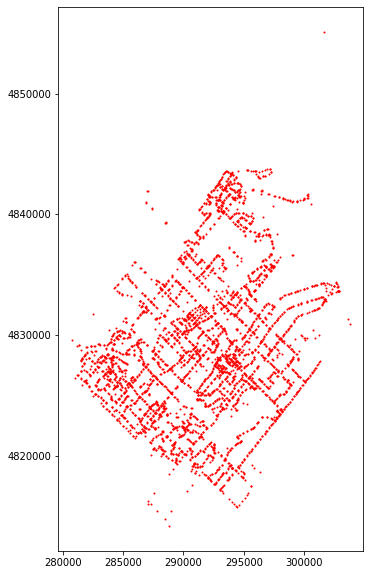

In [189]:
# Plot the stops
ax = miway_stops.plot(figsize=(10,10), color='red', markersize=1)

For some reason there are stops on Ridgeway north of the 403, which I know don't exist. These are perhaps stops that they plan on implementing, so let's filter for stops that are actually active. 

In [198]:
miway_stops[miway_stops['stop_name'].apply(lambda x: 'Ridgeway' in x) ].sample(n=10)

,stop_id,stop_name,latitude,longitude,geometry,x,y,node_ids
3428,place_angrid,Angel Pass/Ridgeway,43.536102,-79.722123,POINT (286847.417 4821605.744),286847.417275,4.821606e+06,7115
808,0955,Ridgeway Dr At Mcmaster Rd,43.518574,-79.694505,POINT (289075.027 4819652.955),289075.026850,4.819653e+06,13841
3438,place_aqnrid,Aquinas/Ridgeway,43.538553,-79.726267,POINT (286513.229 4821878.931),286513.228560,4.821879e+06,11170
787,0931,Ridgeway Dr At Unity Dr,43.532020,-79.716949,POINT (287264.411 4821151.167),287264.411387,4.821151e+06,4223
809,0956,Ridgeway Dr At Dovetail Mews,43.519763,-79.698426,POINT (288758.344 4819785.791),288758.344169,4.819786e+06,6185
810,0957,Ridgeway Dr At The Collegeway,43.523152,-79.704281,POINT (288285.924 4820163.422),288285.923723,4.820163e+06,11486
807,0954,Laird Rd At Ridgeway Dr,43.518667,-79.690754,POINT (289378.304 4819662.585),289378.304364,4.819663e+06,9742
825,0972,Sladeview Cres West Of Ridgeway Dr,43.526395,-79.714754,POINT (287440.216 4820525.821),287440.216125,4.820526e+06,12672
1425,1652,Ridgeway Dr South Of The Collegeway,43.521462,-79.701372,POINT (288520.633 4819975.106),288520.632944,4.819975e+06,15304
1426,1653,Ridgeway Dr At Dovetail Mews,43.519884,-79.698844,POINT (288724.583 4819799.313),288724.583274,4.819799e+06,6185


All the Ridgeway stops that don't exist have stopid's that start with "place". Let's check to see if this is common, so we can avoid using the stop_times dataset to remove unused stops. 

In [194]:
disabled_stops = miway_stops[miway_stops['stop_id'].apply(lambda x: 'place' in x) ]
print("Number of inactive stops: {}/{}".format(disabled_stops.shape[0], miway_stops.shape[0]))
disabled_stops.head()

Number of inactive stops: 927/4313


,stop_id,stop_name,latitude,longitude,geometry,x,y,node_ids
3386,place_401403,401 Hwy W/403 Hwy W,43.644611,-79.650155,POINT (292685.849 4833647.205),292685.848991,4.833647e+06,3841
3387,place_401427,401 HWY E/427 HWY,43.668140,-79.590586,POINT (297494.588 4836254.150),297494.588488,4.836254e+06,3424
3388,place_401dix,401 Hwy/Dixie,43.648316,-79.637573,POINT (293701.617 4834057.046),293701.617283,4.834057e+06,15724
3389,place_401hur,401 Hwy/Hurontario,43.629911,-79.684387,POINT (289920.465 4832019.704),289920.464839,4.832020e+06,9108
3390,place_401isl,401 Hwy/Islington Ave,43.709467,-79.552344,POINT (300581.556 4840842.671),300581.555581,4.840843e+06,8696


After looking at this and quickly checking the stop_times dataset, we can see that no active stops have a stop id of type string. These stops can thusly be removed. 

In [199]:
miway_stops = miway_stops[miway_stops['stop_id'].apply(lambda x: 'place' not in x)]

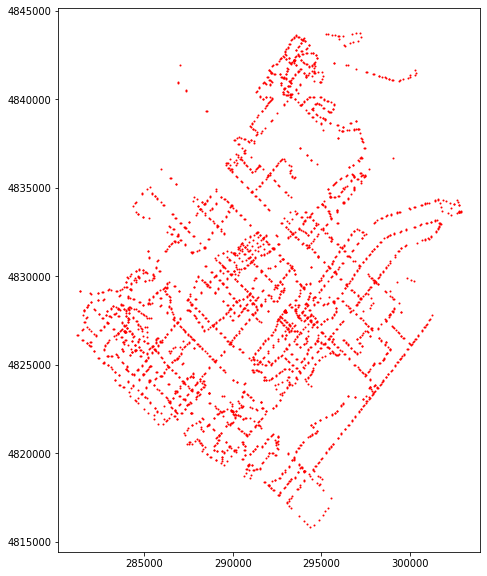

In [200]:
# Plot the stops
ax = miway_stops.plot(figsize=(10,10), color='red', markersize=1)

### Road and Trail network
We'll need to combine the region of peel's trail and road network datasets and filter for those that are in Mississauga in order to find walkable paths. 

In [23]:
peel_roads = gpd.read_file('./Data/streets.geojson')
peel_roads.head()

,MUNC,PRIVATE,ST_NAME,ST_TYPE,ST_DIR,PROVFREEWY,PROVHIGHWY,REG_ROAD,SECTION,ST_CLASS,ST_NAMEAKA,ST_TYPEAKA,ST_DIRAKA,ST_NAMEPRE,ST_TYPEPRE,ST_DIRPRE,FULLSTNAME,ST_NEW,ST_NEWDATE,ST_TYPEABB,OLD_SECTN,SPEEDLIMIT,NO_OF_LANE,CUR_RDCLS,ROUTE_TYPE,GDO_GID,ROPSTSEGID,LFADD,LTADD,RFADD,RTADD,PLN_ROW_M,PLN_ROW_FT,PLN_ROW_ST,ADDR_CHK_S,ADDR_CHK_D,TILEINDEX_,ST_LABEL,SEGMENT_ID,ONEWAY,ST_SURFACE,LADDPARITY,RADDPARITY,L_POSTCODE,R_POSTCODE,L_MUN,R_MUN,TOLL,ST_STRUCTU,ACC_AUTO,ACC_BUS,ACC_PEDEST,ACC_TRUCK,ACC_THRUTR,ACC_DELIVE,ACC_EMERGV,Creator_Na,Editor_Nam,Edit_Date,Shape_STLe,Create_Dat,geometry
0,10,No,River View,Dr,None,None,None,None,None,Local Road - Minor,None,None,None,None,None,None,River View Dr,None,None,Dr,None,50.0,2.0,Local / Street,None,6015.0,1004.0,10.0,38.0,11.0,27.0,0.0,0.0,None,None,None,C,River View Dr,6015.0,No,Asphalt,Even,Odd,L6W,L6W,Brampton,Brampton,N,None,Y,Y,Y,Y,Y,Y,Y,None,KEVIN_FARRUGIA,2017-10-16,318.998120,None,"LINESTRING (-79.73476 43.66993, -79.73545 43.6..."
1,10,No,River View,Dr,None,None,None,None,None,Local Road - Minor,None,None,None,None,None,None,River View Dr,None,None,Dr,None,50.0,2.0,Local / Street,None,6016.0,1006.0,2.0,8.0,1.0,5.0,0.0,0.0,None,None,None,C,River View Dr,6016.0,No,Asphalt,Even,Odd,L6W,L6W,Brampton,Brampton,N,None,Y,Y,Y,Y,Y,Y,Y,None,KEVIN_FARRUGIA,2017-10-16,95.007527,None,"LINESTRING (-79.73358 43.66991, -79.73476 43.6..."
2,10,No,Smithers,Cres,None,None,None,None,None,Local Road - Minor,None,None,None,None,None,None,Smithers Cres,None,None,Cr,None,50.0,2.0,Local / Street,None,9431.0,1505.0,1.0,29.0,2.0,44.0,0.0,0.0,None,None,None,C,Smithers Cr,9431.0,No,Asphalt,Odd,Even,L6Y,L6Y,Brampton,Brampton,N,None,Y,Y,Y,Y,Y,Y,Y,None,KEVIN_FARRUGIA,2017-10-16,274.749375,None,"LINESTRING (-79.74173 43.66283, -79.74310 43.6..."
3,10,No,Denlow,Dr,None,None,None,None,None,Local Road - Minor,None,None,None,None,None,None,Denlow Dr,None,None,Dr,None,50.0,2.0,Local / Street,None,9210.0,1513.0,46.0,64.0,27.0,41.0,0.0,0.0,None,None,None,C,Denlow Dr,9210.0,No,Asphalt,Even,Odd,L6Y,L6Y,Brampton,Brampton,N,None,Y,Y,Y,Y,Y,Y,Y,None,KEVIN_FARRUGIA,2017-10-16,116.410116,None,"LINESTRING (-79.74813 43.65753, -79.74711 43.6..."
4,10,No,Hudson,Dr,None,None,None,None,None,Local Road - Minor,None,None,None,None,None,None,Hudson Dr,None,None,Dr,None,50.0,2.0,Local / Street,None,9211.0,1514.0,2.0,46.0,1.0,19.0,0.0,0.0,None,None,None,C,Hudson Dr,9211.0,No,Asphalt,Even,Odd,L6Y,L6Y,Brampton,Brampton,N,None,Y,Y,Y,Y,Y,Y,Y,None,GISPRD\kevin_farrugia,2018-02-15,203.157710,None,"LINESTRING (-79.74934 43.65430, -79.74832 43.6..."


In [116]:
# Filter for Mississauga roads with pedestrian access
crs = {'init': 'epsg:4326'}
sauga_roads = peel_roads[(peel_roads['L_MUN'] == 'Mississauga') & (peel_roads['ACC_PEDEST'] == 'Y')][['geometry']]
sauga_roads = gpd.GeoDataFrame(sauga_roads, crs=crs, geometry='geometry')
sauga_roads = sauga_roads.to_crs({'init': 'epsg:2019'})
sauga_roads.head()

,geometry
11294,"LINESTRING (284582.159 4825933.768, 284565.529..."
11295,"LINESTRING (284492.428 4825827.125, 284173.416..."
11296,"LINESTRING (284614.898 4824543.007, 284560.850..."
11297,"LINESTRING (284668.696 4824499.523, 284614.898..."
11298,"LINESTRING (284694.694 4824290.985, 284635.601..."


In [117]:
peel_trails = gpd.read_file('zip://./Data/trails_shp.zip')
peel_trails.head()

,Name,Class,Surface,MUN,Crossing,BruceTrail,TransCanTr,OakridgeTr,Waterfront,GrnbeltRte,Creator_Na,Create_Dat,Editor_Nam,Edit_Date,Length,geometry
0,None,Paved Multi-use Trail,Asphalt,Brampton,None,None,None,None,None,None,None,None,10482,2014-01-21,160.713365,"LINESTRING (600184.708 4836625.682, 600219.427..."
1,Waterfront Trail,Paved Multi-use Trail,Asphalt,Mississauga,None,None,Yes,None,Yes,None,None,None,10482,2014-08-11,3751.420932,"LINESTRING (610964.218 4815377.396, 610967.925..."
2,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,161.058070,"LINESTRING (610146.090 4825995.810, 610145.940..."
3,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,137.794178,"LINESTRING (610146.090 4825995.810, 610147.287..."
4,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,12.882138,"LINESTRING (610145.940 4825985.782, 610148.516..."


In [118]:
print(peel_trails.crs)
peel_trails = sauga_trails.to_crs({'init':'epsg:2019'})

{'init': 'epsg:26917'}


In [119]:
sauga_trails = peel_trails[peel_trails['MUN'] == 'Mississauga']
sauga_trails.head()

,Name,Class,Surface,MUN,Crossing,BruceTrail,TransCanTr,OakridgeTr,Waterfront,GrnbeltRte,Creator_Na,Create_Dat,Editor_Nam,Edit_Date,Length,geometry
1,Waterfront Trail,Paved Multi-use Trail,Asphalt,Mississauga,None,None,Yes,None,Yes,None,None,None,10482,2014-08-11,3751.420932,"LINESTRING (294459.902 4815700.142, 294463.621..."
2,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,161.058070,"LINESTRING (293833.265 4826333.073, 293832.935..."
3,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,137.794178,"LINESTRING (293833.265 4826333.073, 293834.819..."
4,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,12.882138,"LINESTRING (293832.935 4826323.048, 293835.511..."
5,None,Paved Multi-use Trail,Asphalt,Mississauga,None,None,None,None,None,None,None,None,10482,2014-01-21,656.764489,"LINESTRING (293583.161 4826524.252, 293596.082..."


In [120]:
sauga_paths = sauga_trails[['geometry']].append(sauga_roads)
sauga_paths = gpd.GeoDataFrame(sauga_paths, geometry='geometry')
sauga_paths.head()

,geometry
1,"LINESTRING (294459.902 4815700.142, 294463.621..."
2,"LINESTRING (293833.265 4826333.073, 293832.935..."
3,"LINESTRING (293833.265 4826333.073, 293834.819..."
4,"LINESTRING (293832.935 4826323.048, 293835.511..."
5,"LINESTRING (293583.161 4826524.252, 293596.082..."


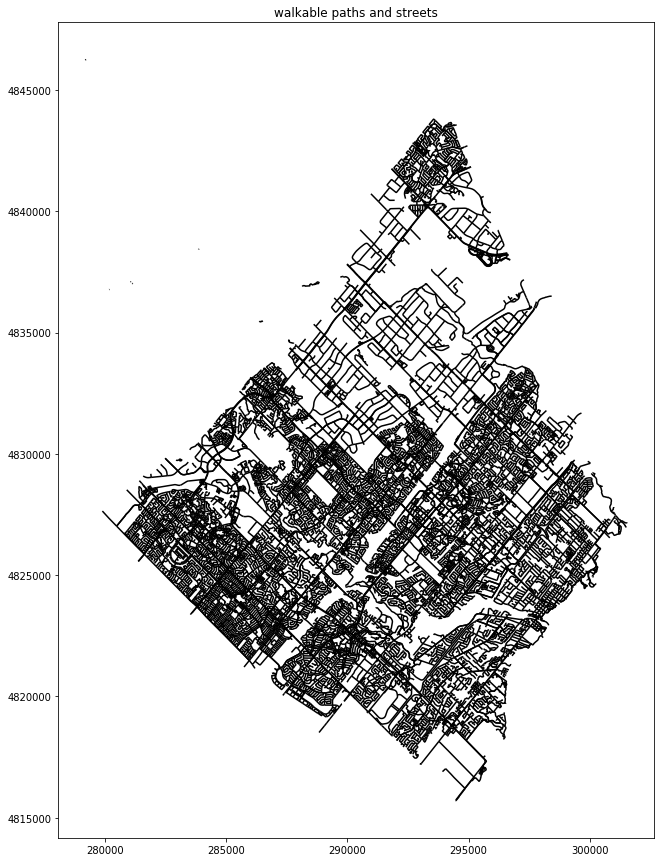

In [121]:
ax = sauga_paths.plot(figsize=(15,15), color='black')
ax.set_title('walkable paths and streets')
plt.show()

### Address Data

In [92]:
peel_addresses = pd.read_csv('./Data/AddressPoints_csv.csv')
peel_addresses.head()

,XCoord,YCoord,STREETNUM,UNIT_IDENTIFIER,STREETNAME,STREETDIRECTION,STREETTYPE,MUNICIPALITY,ROPADRID,LATITUDE,LONGITUDE
0,603018.2937,4.825209e+06,25,,ALPHONSE,,CRES,Mississauga,943.0,43.572725,-79.724193
1,603059.9729,4.825170e+06,29,,ALPHONSE,,CRES,Mississauga,944.0,43.572372,-79.723685
2,603474.8023,4.825487e+06,14,,MERRYDREW,,CRT,Mississauga,945.0,43.575164,-79.718488
3,603500.9384,4.825486e+06,10,,MERRYDREW,,CRT,Mississauga,946.0,43.575152,-79.718165
4,603310.4341,4.825691e+06,133,,BONHAM,,BLVD,Mississauga,947.0,43.577023,-79.720484


In [149]:
sauga_addresses = peel_addresses[peel_addresses['MUNICIPALITY'] == 'Mississauga']
sauga_addresses['geometry'] = list(zip(sauga_addresses['LONGITUDE'], sauga_addresses['LATITUDE']))
sauga_addresses['geometry'] = sauga_addresses['geometry'].apply(Point)

crs = {'init': 'epsg:4326'}
sauga_addresses = gpd.GeoDataFrame(sauga_addresses, crs=crs, geometry='geometry')
sauga_addresses = sauga_addresses.to_crs({'init':'epsg:2019'})
sauga_addresses = sauga_addresses.rename(columns={'XCoord':'x', 'YCoord': 'y'})
sauga_addresses['x'] = sauga_addresses['geometry'].apply(lambda point: point.x)
sauga_addresses['y'] = sauga_addresses['geometry'].apply(lambda point: point.y)
sauga_addresses.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x,y,STREETNUM,UNIT_IDENTIFIER,STREETNAME,STREETDIRECTION,STREETTYPE,MUNICIPALITY,ROPADRID,LATITUDE,LONGITUDE,geometry
0,286691.083598,4.825675e+06,25,,ALPHONSE,,CRES,Mississauga,943.0,43.572725,-79.724193,POINT (286691.084 4825674.689)
1,286732.011163,4.825635e+06,29,,ALPHONSE,,CRES,Mississauga,944.0,43.572372,-79.723685,POINT (286732.011 4825635.363)
2,287152.610339,4.825944e+06,14,,MERRYDREW,,CRT,Mississauga,945.0,43.575164,-79.718488,POINT (287152.610 4825944.414)
3,287178.695725,4.825943e+06,10,,MERRYDREW,,CRT,Mississauga,946.0,43.575152,-79.718165,POINT (287178.696 4825943.012)
4,286991.940156,4.826151e+06,133,,BONHAM,,BLVD,Mississauga,947.0,43.577023,-79.720484,POINT (286991.940 4826151.359)


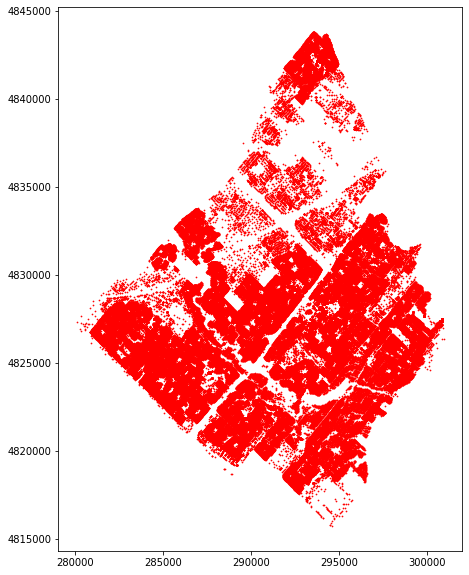

In [99]:
ax = sauga_addresses.plot(figsize=(10,10), color='red', markersize=0.5)

All together the final result looks like this:

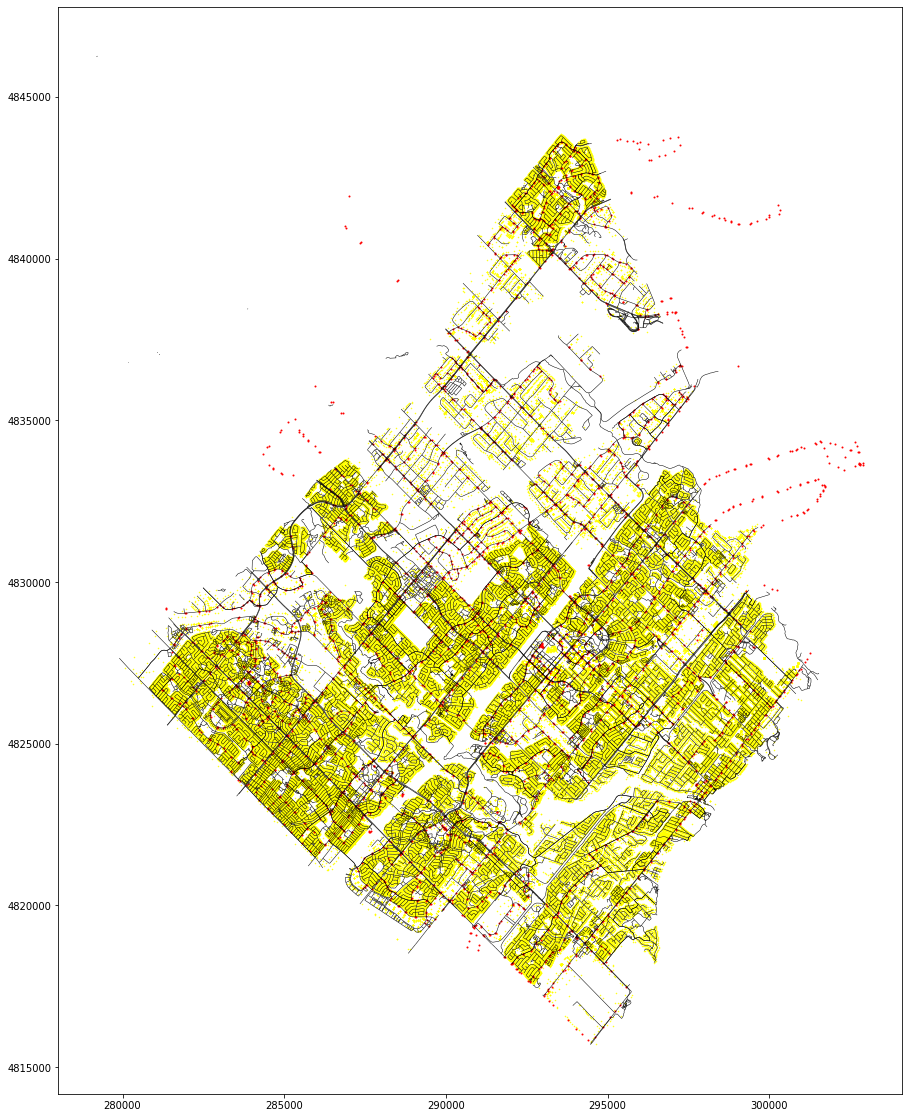

In [202]:
ax = sauga_addresses.plot(figsize=(20,20), color='yellow', markersize=0.25)
miway_stops.plot(figsize=(20,20), ax=ax, color='red', markersize=1)
sauga_paths.plot(figsize=(20,20), color='black', ax=ax, linewidth=0.5)
plt.show()

## Step 2: Build Pandana Network
We will be using Pandana for calculating the shortest path to bus stops

In [203]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

In [204]:
G = create_graph(sauga_paths)

In [205]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [206]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges.head(3)

,from,to,forward,length,visited,geometry,to_node,from_node
0,"(294459.902, 4815700.142)","(294899.692, 4818194.647)",1,3751.996191,0,LINESTRING (294459.9023797661 4815700.14194134...,17464,12535
1,"(294899.692, 4818194.647)","(295110.796, 4818461.437)",1,340.208796,0,LINESTRING (295110.7958600175 4818461.43741707...,4893,17464
2,"(294899.692, 4818194.647)","(293417.248, 4819722.435)",1,2155.881638,0,LINESTRING (294899.6918607206 4818194.64700001...,7045,17464


In [207]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')

**Precompute Horizon Distances**

In [208]:
transit_ped_net.precompute(1000)
transit_ped_net.edges_df.head(2)

,from,to,length
0,12535,17464,3751.996191
1,17464,4893,340.208796


**Get nearest Pedestrian intersection node ids for each point from the address and ttc stop layers**

In [209]:
#get node_ids for points for each layer
x, y = miway_stops.x, miway_stops.y 
miway_stops["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(miway_stops["node_ids"], name="miway_stop")

# using x and y coordinates from address that are utm nad27 
x, y = sauga_addresses.x, sauga_addresses.y
sauga_addresses["node_ids"] = transit_ped_net.get_node_ids(x, y)

**Get 10 Nearest Miway stop points**

In [210]:
n=10
max_distance = 5000

transit_ped_net.set_pois("miway_stop", max_distance, n, miway_stops.x, miway_stops.y)
miway_stops_walk_distances = transit_ped_net.nearest_pois(max_distance, "miway_stop", num_pois=n, include_poi_ids=False)
miway_stops_walk_distances.head(3)

,1,2,3,4,5,6,7,8,9,10
0,15.106000,205.889999,308.187012,333.546997,333.546997,379.368988,513.531982,584.922974,650.469971,669.580994
1,208.244003,220.302994,394.867004,501.473999,505.239014,547.895996,665.956970,665.956970,745.304016,761.849976
2,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000


In [211]:
# Rename columns 1 to 10 to d_miwaystop_0 to d_miwaystop_9.

n=10

columns =  ['d_miwaystop_'+str(i) for i in range(0,n,1)]

miway_stops_walk_distances.columns = columns
miway_stops_walk_distances.sample(5)

,d_miwaystop_0,d_miwaystop_1,d_miwaystop_2,d_miwaystop_3,d_miwaystop_4,d_miwaystop_5,d_miwaystop_6,d_miwaystop_7,d_miwaystop_8,d_miwaystop_9
8053,0.000000,188.279007,200.494003,200.494003,200.494003,290.625000,382.148010,382.148010,382.148010,382.148010
5802,455.790009,527.809021,550.320007,616.166992,619.156006,854.969971,911.487000,911.487000,1050.885986,1167.208008
9283,300.763000,403.950989,493.638000,493.638000,529.760986,529.760986,611.716980,674.000000,675.620972,737.510986
15897,295.173004,305.454987,358.058990,380.080994,528.213013,565.679993,565.679993,733.557983,742.208008,804.739990
3735,95.622002,95.622002,246.425003,246.425003,260.468994,260.468994,418.915985,457.324005,457.324005,574.966980


**Calculating walk distance from address point to miway stops and get each point id from the stop.**

In [212]:
for i in range(10):
    sauga_addresses['d_miwaystop_{}'.format(i)]=sauga_addresses['node_ids'].map(miway_stops_walk_distances['d_miwaystop_{}'.format(i)])
sauga_addresses.head(2)

,x,y,STREETNUM,UNIT_IDENTIFIER,STREETNAME,STREETDIRECTION,STREETTYPE,MUNICIPALITY,ROPADRID,LATITUDE,LONGITUDE,geometry,node_ids,d_miwaystop_0,d_miwaystop_1,d_miwaystop_2,d_miwaystop_3,d_miwaystop_4,d_miwaystop_5,d_miwaystop_6,d_miwaystop_7,d_miwaystop_8,d_miwaystop_9,m_miwaystop_0,m_miwaystop_1,m_miwaystop_2,m_miwaystop_3,m_miwaystop_4,m_miwaystop_5,m_miwaystop_6,m_miwaystop_7,m_miwaystop_8,m_miwaystop_9
0,286691.083598,4.825675e+06,25,,ALPHONSE,,CRES,Mississauga,943.0,43.572725,-79.724193,POINT (286691.084 4825674.689),13457,184.888000,337.786011,375.867004,390.592987,390.592987,444.683990,465.368988,545.966980,555.984985,695.698975,2.567889,4.691472,5.220375,5.424903,5.424903,6.176167,6.176167,6.463458,7.582875,7.722014
1,286732.011163,4.825635e+06,29,,ALPHONSE,,CRES,Mississauga,944.0,43.572372,-79.723685,POINT (286732.011 4825635.363),14751,351.393005,420.209991,440.894989,465.015015,465.015015,542.372009,620.388977,630.406982,695.270020,770.120972,4.880458,5.836250,5.836250,6.123542,6.458542,6.458542,7.532945,8.616514,8.755653,9.055917


**Calculate minutes fields based on distances**
We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf


In [213]:
sauga_addresses['m_miwaystop_0'] = sauga_addresses.apply(lambda row: row.d_miwaystop_0/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_1'] = sauga_addresses.apply(lambda row: row.d_miwaystop_1/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_2'] = sauga_addresses.apply(lambda row: row.d_miwaystop_2/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_3'] = sauga_addresses.apply(lambda row: row.d_miwaystop_3/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_4'] = sauga_addresses.apply(lambda row: row.d_miwaystop_4/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_5'] = sauga_addresses.apply(lambda row: row.d_miwaystop_5/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_6'] = sauga_addresses.apply(lambda row: row.d_miwaystop_6/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_7'] = sauga_addresses.apply(lambda row: row.d_miwaystop_7/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_8'] = sauga_addresses.apply(lambda row: row.d_miwaystop_8/(1.2*60), axis=1)
sauga_addresses['m_miwaystop_9'] = sauga_addresses.apply(lambda row: row.d_miwaystop_9/(1.2*60), axis=1)
sauga_addresses.head(3)

,x,y,STREETNUM,UNIT_IDENTIFIER,STREETNAME,STREETDIRECTION,STREETTYPE,MUNICIPALITY,ROPADRID,LATITUDE,LONGITUDE,geometry,node_ids,d_miwaystop_0,d_miwaystop_1,d_miwaystop_2,d_miwaystop_3,d_miwaystop_4,d_miwaystop_5,d_miwaystop_6,d_miwaystop_7,d_miwaystop_8,d_miwaystop_9,m_miwaystop_0,m_miwaystop_1,m_miwaystop_2,m_miwaystop_3,m_miwaystop_4,m_miwaystop_5,m_miwaystop_6,m_miwaystop_7,m_miwaystop_8,m_miwaystop_9
0,286691.083598,4.825675e+06,25,,ALPHONSE,,CRES,Mississauga,943.0,43.572725,-79.724193,POINT (286691.084 4825674.689),13457,184.888000,337.786011,375.867004,390.592987,390.592987,444.683990,465.368988,545.966980,555.984985,695.698975,2.567889,4.691472,5.220375,5.424903,5.424903,6.176167,6.463458,7.582875,7.722014,9.662486
1,286732.011163,4.825635e+06,29,,ALPHONSE,,CRES,Mississauga,944.0,43.572372,-79.723685,POINT (286732.011 4825635.363),14751,351.393005,420.209991,440.894989,465.015015,465.015015,542.372009,620.388977,630.406982,695.270020,770.120972,4.880458,5.836250,6.123542,6.458542,6.458542,7.532945,8.616514,8.755653,9.656528,10.696125
2,287152.610339,4.825944e+06,14,,MERRYDREW,,CRT,Mississauga,945.0,43.575164,-79.718488,POINT (287152.610 4825944.414),6831,247.035995,303.950989,409.404999,467.356995,503.782013,511.984985,511.984985,537.361023,652.320984,677.377014,3.431055,4.221542,5.686181,6.491069,6.996972,7.110903,7.110903,7.463348,9.060014,9.408014


## Step 3: Visualize Walking Times
### Walk Times to Closest MiWay Stop

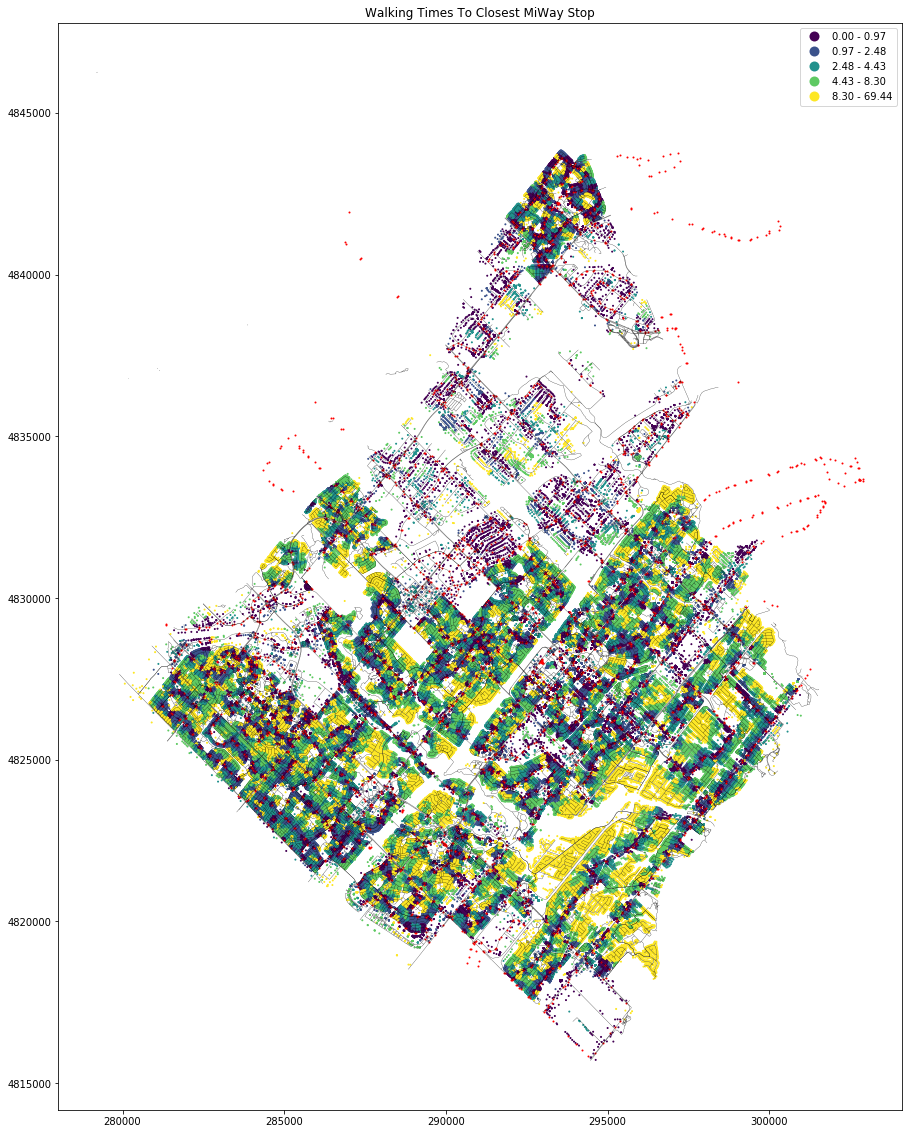

In [214]:
ax = sauga_paths.plot(figsize=(20, 20), color='black', linewidth=0.25)
sauga_addresses.plot(ax = ax, column='m_miwaystop_0', scheme='quantiles', legend=True,markersize = 1)
miway_stops.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest MiWay Stop')
plt.savefig('./walking_times500dpi.png', dpi=500)
plt.savefig('./walking_times300dpi.png', dpi=300)
plt.savefig('./walking_times100dpi.png', dpi=100)
plt.show()

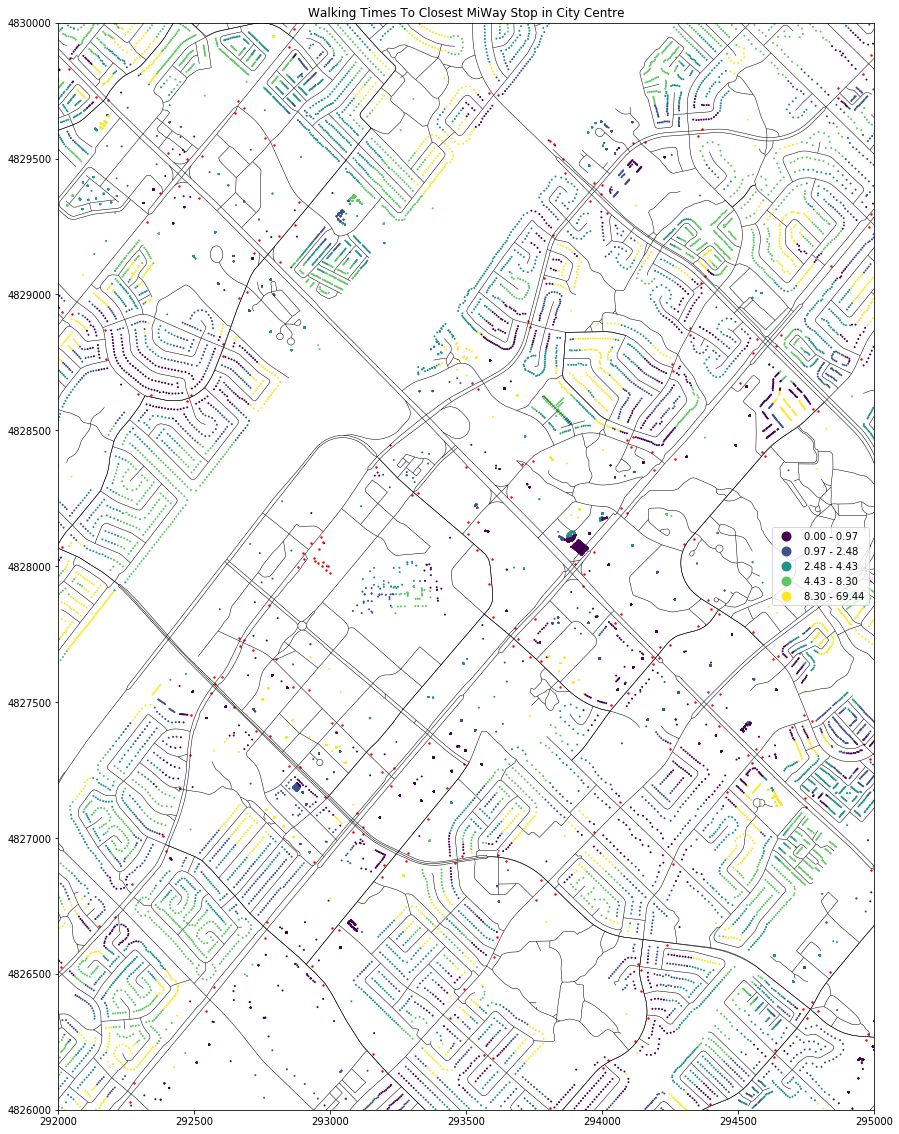

In [215]:
ax = sauga_addresses.plot(figsize=(20,20),column='m_miwaystop_0', scheme='quantiles', legend=True,markersize = 1)#.plot(ax-ax,figsize=(20, 20), color='black')
miway_stops.plot(ax=ax, color='red', markersize =2)
sauga_paths.plot(ax=ax, color='black', linewidth=0.5)
ax.set(xlim=(292000, 295000), ylim=(4826000, 4830000))
plt.title('Walking Times To Closest MiWay Stop in City Centre')
plt.show()